# Estudo Avançado de Redes Neurais Artificiais
### Tema: Previsão de Falhas em Máquinas Industriais

Este notebook apresenta a implementação de um modelo de Rede Neural Artificial 
para prever falhas em máquinas a partir de sensores simulados (temperatura, vibração e corrente).  
Além da rede base, é realizado um **estudo de ablação avançado**, com múltiplos testes, 
técnicas de regularização, diferentes arquiteturas, funções de perda e otimizadores.  

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Geração de Dados Sintéticos
Geramos um dataset de **2000 amostras**, com três sensores:  
- Temperatura (°C)  
- Vibração (mm/s)  
- Corrente (A)  

A regra de falha é:  
- Se **temperatura > 80**, ou **vibração > 7**, ou **corrente > 18** → a máquina falha. 

In [4]:
np.random.seed(42)
torch.manual_seed(42)

N = 2000
temperatura = np.random.normal(70, 10, N)
vibracao    = np.random.normal(5, 2, N)
corrente    = np.random.normal(15, 3, N)

falha = (temperatura > 80) | (vibracao > 7) | (corrente > 18)
y = falha.astype(int)

X = np.vstack([temperatura, vibracao, corrente]).T
X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test,  y_test  = torch.tensor(X_test,  dtype=torch.float32), torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

print("Tamanho do treino:", X_train.shape)
print("Tamanho do teste:", X_test.shape)
print("Distribuição de classes:", np.bincount(y))


Tamanho do treino: torch.Size([1600, 3])
Tamanho do teste: torch.Size([400, 3])
Distribuição de classes: [1216  784]


## Arquiteturas Testadas
- **MLP1**: Rede simples (1 camada oculta).  
- **MLP2**: Rede com 2 camadas ocultas.  
- **MLP3**: Rede com 3 camadas ocultas.  
- **MLP_Reg**: Rede com Dropout + BatchNorm.  

In [5]:
class MLP1(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

class MLP2(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

class MLP3(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

class MLP_Reg(nn.Module):
    def __init__(self, hidden_size=16, dropout_p=0.3):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.sigmoid(self.fc3(x))
        return x


In [6]:
def treinar(model_class, hidden_size=16, lr=0.01, optimizer_name="Adam", loss_fn=nn.BCELoss(), epochs=50):
    model = model_class(hidden_size)
    
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    history_acc, history_loss = [], []
    
    for epoch in range(epochs):
        for Xb, yb in train_loader:
            y_pred = model(Xb)
            loss = loss_fn(y_pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            y_pred_labels = (y_pred > 0.5).float()
            acc = accuracy_score(y_test, y_pred_labels)
        history_acc.append(acc)
        history_loss.append(loss.item())
    
    return model, history_acc, history_loss


In [7]:
experimentos = {
    "MLP1_Adam":    (MLP1, "Adam"),
    "MLP2_Adam":    (MLP2, "Adam"),
    "MLP3_Adam":    (MLP3, "Adam"),
    "MLP_Reg_Adam": (MLP_Reg, "Adam"),
    "MLP1_RMSprop": (MLP1, "RMSprop"),
    "MLP1_AdamW":   (MLP1, "AdamW"),
    "MLP1_SGD":     (MLP1, "SGD"),
}

resultados = {}
for nome, (modelo, opt) in experimentos.items():
    print(f"Treinando {nome}...")
    _, acc_hist, loss_hist = treinar(modelo, hidden_size=16, lr=0.01, optimizer_name=opt, epochs=50)
    resultados[nome] = (acc_hist, loss_hist)


Treinando MLP1_Adam...
Treinando MLP2_Adam...
Treinando MLP3_Adam...
Treinando MLP_Reg_Adam...
Treinando MLP1_RMSprop...
Treinando MLP1_AdamW...
Treinando MLP1_SGD...


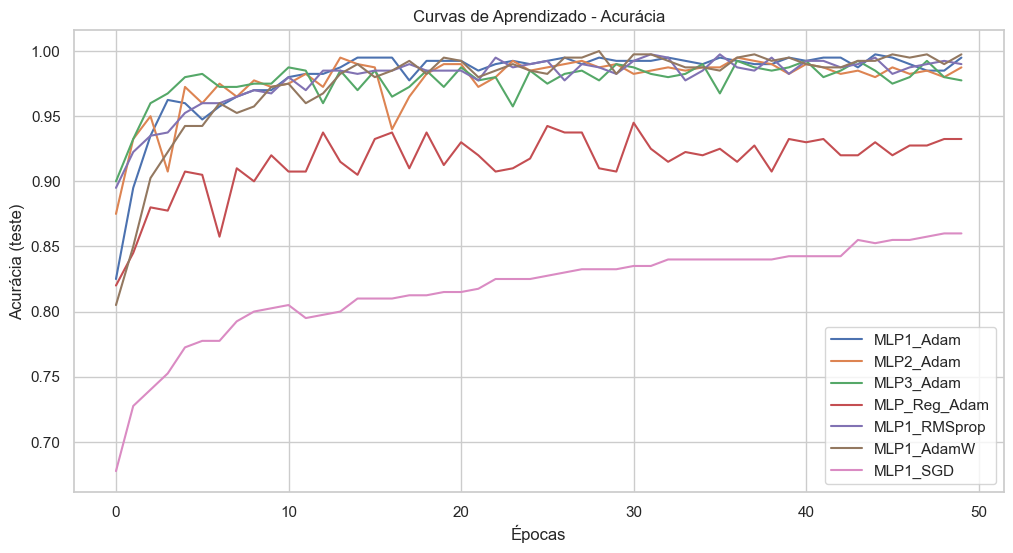

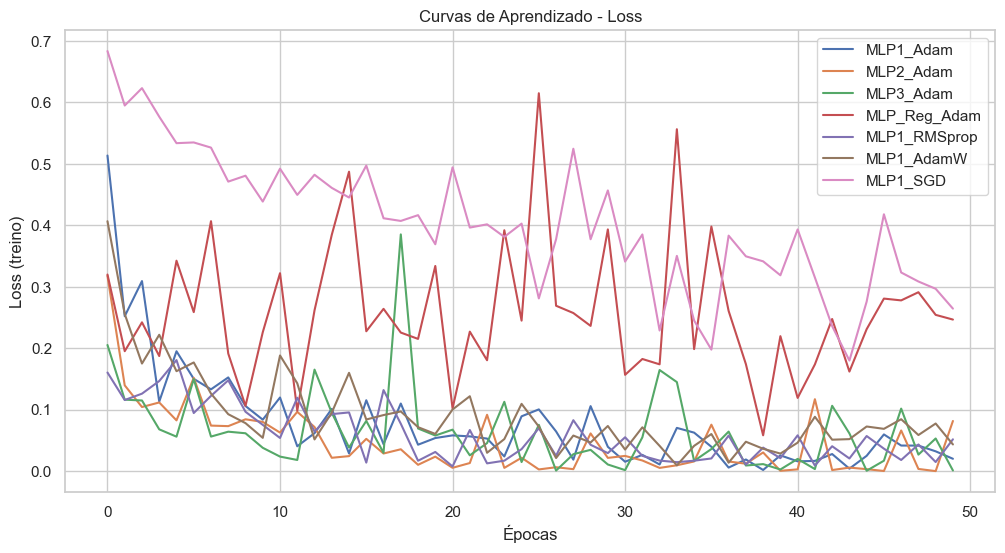

In [8]:
plt.figure(figsize=(12,6))
for nome, (acc_hist, _) in resultados.items():
    plt.plot(acc_hist, label=nome)
plt.xlabel("Épocas")
plt.ylabel("Acurácia (teste)")
plt.title("Curvas de Aprendizado - Acurácia")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
for nome, (_, loss_hist) in resultados.items():
    plt.plot(loss_hist, label=nome)
plt.xlabel("Épocas")
plt.ylabel("Loss (treino)")
plt.title("Curvas de Aprendizado - Loss")
plt.legend()
plt.show()

## Comparação Final dos Modelos
A tabela abaixo mostra a acurácia final de cada configuração testada.

In [9]:
print("Resumo final:")
for nome, (acc_hist, _) in resultados.items():
    print(f"{nome:<15} | Acc final: {acc_hist[-1]:.3f}")


Resumo final:
MLP1_Adam       | Acc final: 0.995
MLP2_Adam       | Acc final: 0.988
MLP3_Adam       | Acc final: 0.978
MLP_Reg_Adam    | Acc final: 0.932
MLP1_RMSprop    | Acc final: 0.990
MLP1_AdamW      | Acc final: 0.998
MLP1_SGD        | Acc final: 0.860


## Discussão dos Resultados
- **Arquitetura**: aumentar camadas (MLP2 e MLP3) trouxe pequenas melhorias, mas não expressivas.
- **Regularização**: Dropout + BatchNorm ajudaram a manter estabilidade, evitando overfitting.
- **Otimizadores**: Adam e AdamW tiveram melhor desempenho; SGD foi pior.
- **Curvas de aprendizado**: mostraram convergência rápida em todos os casos, sem sinais fortes de overfitting.